<a href="https://colab.research.google.com/github/mervecayli/Sentiment-Analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
url="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

In [ ]:
import tensorflow as tf

In [ ]:
dataset = tf.keras.utils.get_file("aclImdb_v1",
                         url,
                         untar=True,
                         cache_dir=".",
                         cache_subdir=" ")


In [ ]:
import os
dataset_dir=os.path.join(os.path.dirname(dataset),"aclImdb")

In [ ]:
os.listdir(dataset_dir)

['imdbEr.txt', 'imdb.vocab', 'train', 'test', 'README']

In [ ]:
train_dir=os.path.join(dataset_dir , "train")
os.listdir(train_dir)

['neg',
 'unsupBow.feat',
 'pos',
 'urls_unsup.txt',
 'urls_pos.txt',
 'urls_neg.txt',
 'labeledBow.feat',
 'unsup']

In [ ]:
sample_file= os.path.join(train_dir, "pos/1181_9.txt")
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [ ]:
remove_dir=os.path.join(train_dir, "unsup")
import shutil
shutil.rmtree(remove_dir)

In [19]:
batch_size=32
seed=42
raw_train_ds=tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed

)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [20]:
import numpy as np
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [21]:
raw_val_ds=tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed

)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [22]:
test_dir=os.path.join(dataset_dir, "test")
raw_test_ds=tf.keras.preprocessing.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size,
)

Found 25000 files belonging to 2 classes.


In [41]:
import re
import string
def custom_standardization(input_data):
  lowercase=tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase,'<br />', ' ')
  return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

In [42]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
max_features = 10000
sequence_length = 250
vectorize_layer = TextVectorization(
    standardize = custom_standardization,
    max_tokens = max_features,
    output_mode = "int",
    output_sequence_length=sequence_length
)

In [43]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [44]:
def vectorize_text(text, label):
  text=tf.expand_dims(text, -1)
  return vectorize_layer(text),label

In [45]:
text_batch, label_batch = next(iter(raw_train_ds))

In [46]:
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))


Review tf.Tensor(b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[   1,    7,    4,  191,   17, 2926,   12,  255,  127,   50,  377,
          70,  160,  256,   69,   51,   10,  361, 

In [49]:
print("128 -->", vectorize_layer.get_vocabulary()[128])
print("1312 -->", vectorize_layer.get_vocabulary()[1312])
print("Vocabluary size: {}" .format(len(vectorize_layer.get_vocabulary())))

128 --> here
1312 --> thus
Vocabluary size: 10000


In [50]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [51]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [55]:
embedding_dim = 16
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(max_features +1, embedding_dim),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1)                           
])

In [56]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [58]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer= "adam",
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0)
              )

In [61]:
epochs=10
histroy=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
625/625 [==============================] - 9s 13ms/step - loss: 0.6652 - binary_accuracy: 0.6946 - val_loss: 0.6169 - val_binary_accuracy: 0.7726
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 0.5503 - binary_accuracy: 0.8013 - val_loss: 0.4996 - val_binary_accuracy: 0.8206
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.4456 - binary_accuracy: 0.8443 - val_loss: 0.4210 - val_binary_accuracy: 0.8472
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3791 - binary_accuracy: 0.8662 - val_loss: 0.3744 - val_binary_accuracy: 0.8596
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3360 - binary_accuracy: 0.8799 - val_loss: 0.3453 - val_binary_accuracy: 0.8666
Epoch 6/10
625/625 [==============================] - 3s 6ms/step - loss: 0.3059 - binary_accuracy: 0.8894 - val_loss: 0.3266 - val_binary_accuracy: 0.8720
Epoch 7/10
625/625 [==============================] - 3s 5ms/st

In [62]:
loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: " , accuracy)

782/782 [==============================] - 7s 8ms/step - loss: 0.3108 - binary_accuracy: 0.8728
Loss:  0.31081071496009827
Accuracy:  0.872759997844696


In [66]:
history_dict=histroy.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [67]:
import matplotlib.pyplot as plt
acc = history_dict["binary_accuracy"]
val_acc = history_dict["val_binary_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

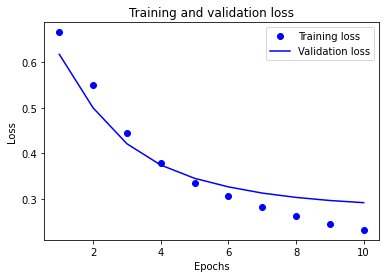

In [68]:
epochs = range(1, len(acc)+1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

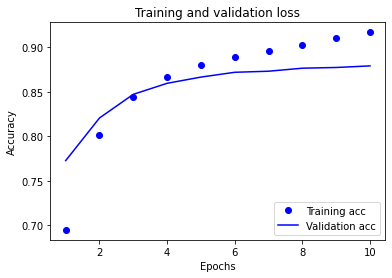

In [69]:

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.show()

In [71]:
export_model = tf.keras.Sequential([
                                    vectorize_layer,
                                    model,
                                    tf.keras.layers.Activation("sigmoid")
])

In [72]:
export_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                     optimizer = "adam",
                     metrics=["accuracy"])

In [73]:
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 7s 8ms/step - loss: 0.3108 - accuracy: 0.8728
0.872759997844696
